In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

#Declare a Base using 'automap_base()'

Base = automap_base()

In [5]:
# reflect an existing database into a new model
# reflect the tables

Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

print(Measurement)
print(Station)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [8]:
#explore columns for Measurement class
[column for column in Measurement.__table__.columns]


[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [9]:
#explore columns for Station class 
[column for column in Station.__table__.columns]

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

In [10]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

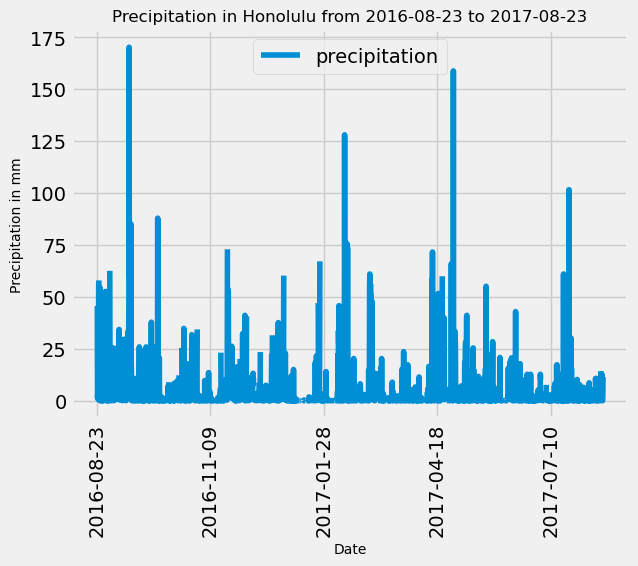

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365) #2016-08-23
# print(year_ago)

# Perform a query to retrieve the data and precipitation scores
year_data = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date >= year_ago).all() 
# year_data
# Save the query results as a Pandas DataFrame. Explicitly set the column names

year_data_df = pd.DataFrame(year_data, columns=['precipitation', 'date'])

#sort by date
sorted_df_prcp = year_data_df.sort_values(by='date')

#plot precipitation over 2016-08-23 to 2017-08-23
#Use Pandas Plotting with Matplotlib to plot the data

sorted_df_prcp.plot('date', 'precipitation', rot=90)
plt.title("Precipitation in Honolulu from 2016-08-23 to 2017-08-23", fontsize=12)
plt.xlabel("Date", fontsize=10)
plt.ylabel("Precipitation in mm", fontsize=10)
plt.show()


#RABIT HOLE trying to make plot look the same as challenge using bar :-( --- bed idea! 
# Calculate interval for 5 date values over the length of the dataframe
# interval = len(sorted_df_prcp) // 5

# # Get positions and corresponding dates at the intervals
# positions = list(range(0, len(sorted_df_prcp), interval))
# dates_to_display = sorted_df_prcp['date'].iloc[positions].tolist()

# #create bar chart/plot
# ax = sorted_df_prcp.plot.bar('date', 'precipitation', figsize=(10, 6), width=40)

# # Set the x-axis ticks and labels
# ax.set_xticks(positions)
# ax.set_xticklabels(dates_to_display)
# ax.set_ylim([0, 180])

# plt.title("Precipitation in Honolulu from 2016-08-23 to 2017-08-23")
# plt.xlabel("Date")
# plt.ylabel("Precipitation in mm")
# plt.tight_layout()
# plt.show()


# year_data_df.set_index('date', inplace=True)
# year_data_df.plot.bar()

# plt.show()
# Sort the dataframe by date




In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data - sorted_df_prcp
quantiles = [0.25, 0.5, 0.75]
quantiles_prcp_df = year_data_df['precipitation'].describe(percentiles=quantiles)
quantiles_prcp_df = quantiles_prcp_df.reset_index()
quantiles_prcp_df.columns = ['Stat Name', 'Value']
quantiles_prcp_df

,Stat Name,Value
0,count,2021.000000
1,mean,4.505888
2,std,11.713487
3,min,0.000000
4,25%,0.000000
5,50%,0.500000
6,75%,3.300000
7,max,170.200000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
total_stations_2 = session.query(Measurement.station).distinct().count() #validating this on Measurment Class, there should be 9 unique stations
print(total_stations)
print(total_stations_2)


9
9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Group by station and count the number of rows per station
grouped_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

print(grouped_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [16]:
grouped_stations[0][0]

'USC00519281'

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mean_temp = session.query(func.min(Measurement.tobs),
                          func.max(Measurement.tobs),
                          func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

print(mean_temp)


[(12.2, 29.4, 22.03582251082252)]


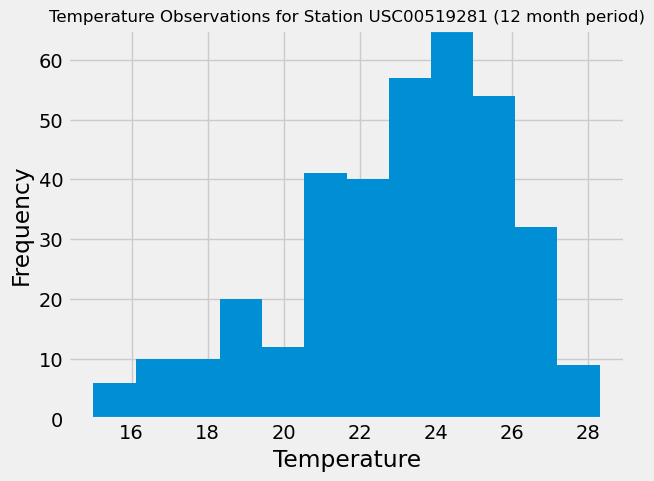

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#find the most recent date for this station id
station_tobs_most_recent_date = session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).first()
# print(station_tobs_most_recent_date) # 2017-08-18

# Calculate the date one year from the last date in data set.
year_ago_station = dt.date(2017, 8, 18) - dt.timedelta(days=365)
# print(year_ago_station) #2016-08-18

#query the last 12 months of temp for station USC00519281
year_ago_station_temp = session.query(Measurement.tobs).filter(Measurement.date >= year_ago_station).filter(Measurement.station == 'USC00519281').all() 
# print(year_ago_station_temp)


#transform to data frame
year_ago_temp_df = pd.DataFrame(year_ago_station_temp, columns=['temperature'])
year_ago_temp_df


# plot the histogram 
year_ago_temp_df['temperature'].plot(kind='hist', bins=12)
plt.title('Temperature Observations for Station USC00519281 (12 month period)', fontsize=12)
plt.xlabel('Temperature')
plt.ylim([0,65])
plt.ylabel('Frequency')
plt.show()
          

# Close Session

In [19]:
# Close Session
session.close()